## EDM Toy Example

With this toy example we illustrate the training efficiency of using CEDM (Conditional Entropy in Diffusion Models). We first: 

1. Re-implemente EDM using torch lightning and demostrate some equivalents to their vs SDE parameterizations.
2. Instead of sampling the noise levels using EDM heuristic samplers we sample from the conditional entropy.
3. Then, we propose our adaptive method.

### 1) DataLoader & Config File

In [ ]:
%load_ext autoreload
%autoreload 2

import hydra
import torch 
import matplotlib.pyplot as plt
from datamodules.toy_datasets import ToyDataModule
from utils.plots import plot_data

from training.losses import *
from training.noise_samplers.schedules import *
from training.noise_samplers.visualize import plot_sigma_distributions, plot_sigma_trajectories
from utils.data_utils import get_datamodule, rescaling_inv

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Loading Dataset...")
# toy_dm = ToyDataModule(dataset_name="swiss_roll", 
#                        num_samples=10000,
#                        noise=0.05,
#                        batch_size=256, 
#                        num_workers=0, 
#                        min_max_normalize=True)

toy_dm = get_datamodule("cifar10", batch_size=4)

toy_dm.prepare_data()
toy_dm.setup()

# Get train dataloader
dataloader = toy_dm.train_dataloader()
x, _ = next(iter(dataloader))

# Plot toy data
fig =plot_data(x)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading Dataset...
Files already downloaded and verified
Files already downloaded and verified


In [2]:
import yaml
from omegaconf import OmegaConf

# Load the default config file 
if not hydra.core.global_hydra.GlobalHydra.instance().is_initialized():
    hydra.initialize(config_path="./config", version_base=None)
    config = hydra.compose(config_name="config")

# Print the config file as yaml
# Convert OmegaConf config to dict before dumping to YAML
config_dict = OmegaConf.to_container(config, resolve=True)
print(yaml.dump(config_dict, default_flow_style=False))

dataset:
  batch_size: 128
  data_dir: .
  fid_sample_shape:
  - 500
  - 3
  - 32
  - 32
  img_resolution: 32
  in_channels: 3
  label_dim: 10
  n_dataset_samples: 50000
  name: cifar10
  num_workers: 16
  out_channels: 3
  plot_type: grid
  sample_shape:
  - 256
  - 3
  - 32
  - 32
logging:
  log_every_n_steps: 50
  mode: min
  monitor: val_loss
  name: diffusion_experiment
  save_dir: results
  save_top_k: 3
  version: '1'
loss:
  P_mean: -1.2
  P_std: 1.2
  name: edm
  sigma_data: 0.5
model:
  class_conditional: false
  label_dim: 0
  name: edm
network:
  channel_mult:
  - 2
  - 2
  - 2
  channel_mult_noise: 1
  decoder_type: standard
  dropout: 0.2
  embedding_type: positional
  encoder_type: standard
  model_channels: 128
  name: ddpmpp
  num_blocks: 4
  reload_url: ''
  resample_filter:
  - 1
  - 1
  return_embeddings: false
  second_time_embedding: false
precond:
  P_mean: -1.2
  P_std: 1.2
  name: edm
  rho: 7.0
  sigma_data: 0.5
  sigma_max: 100.0
  sigma_min: 0.02
sampling:
 

/home/gabriel/miniconda3/envs/entropy/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


### 2) Noise Schedulers and equivalence with SDE formulation

Rather than using complex formulation, EDM proposed to separate its complexity by proposing a unified framework that consists on only looking at the Gaussian kernel,


\begin{equation}
    p_{0t}(\mathbf{x}_t ~|~ \mathbf{x}_0) = \mathcal{N} \big( \mathbf{x}_t; ~s(t) ~\mathbf{x}_0, ~s(t)^2 ~\sigma(t)^2 ~\mathbf{I} \big) 
\end{equation}

To define a general framework, rather than having a noisy state directly by reparameterizing the Gaussian kernel, everything is defined for the VESDE case, where $s(t) =1$. This allows to define a general way to noise data via 

\begin{equation}
    \mathbf{x}_t  = \mathbf{x}_0 + \sigma(t) * \epsilon 
\end{equation}

The equivalence from VE to VP is possible by scaling the function, in practice this is done by a preconditioning network. 

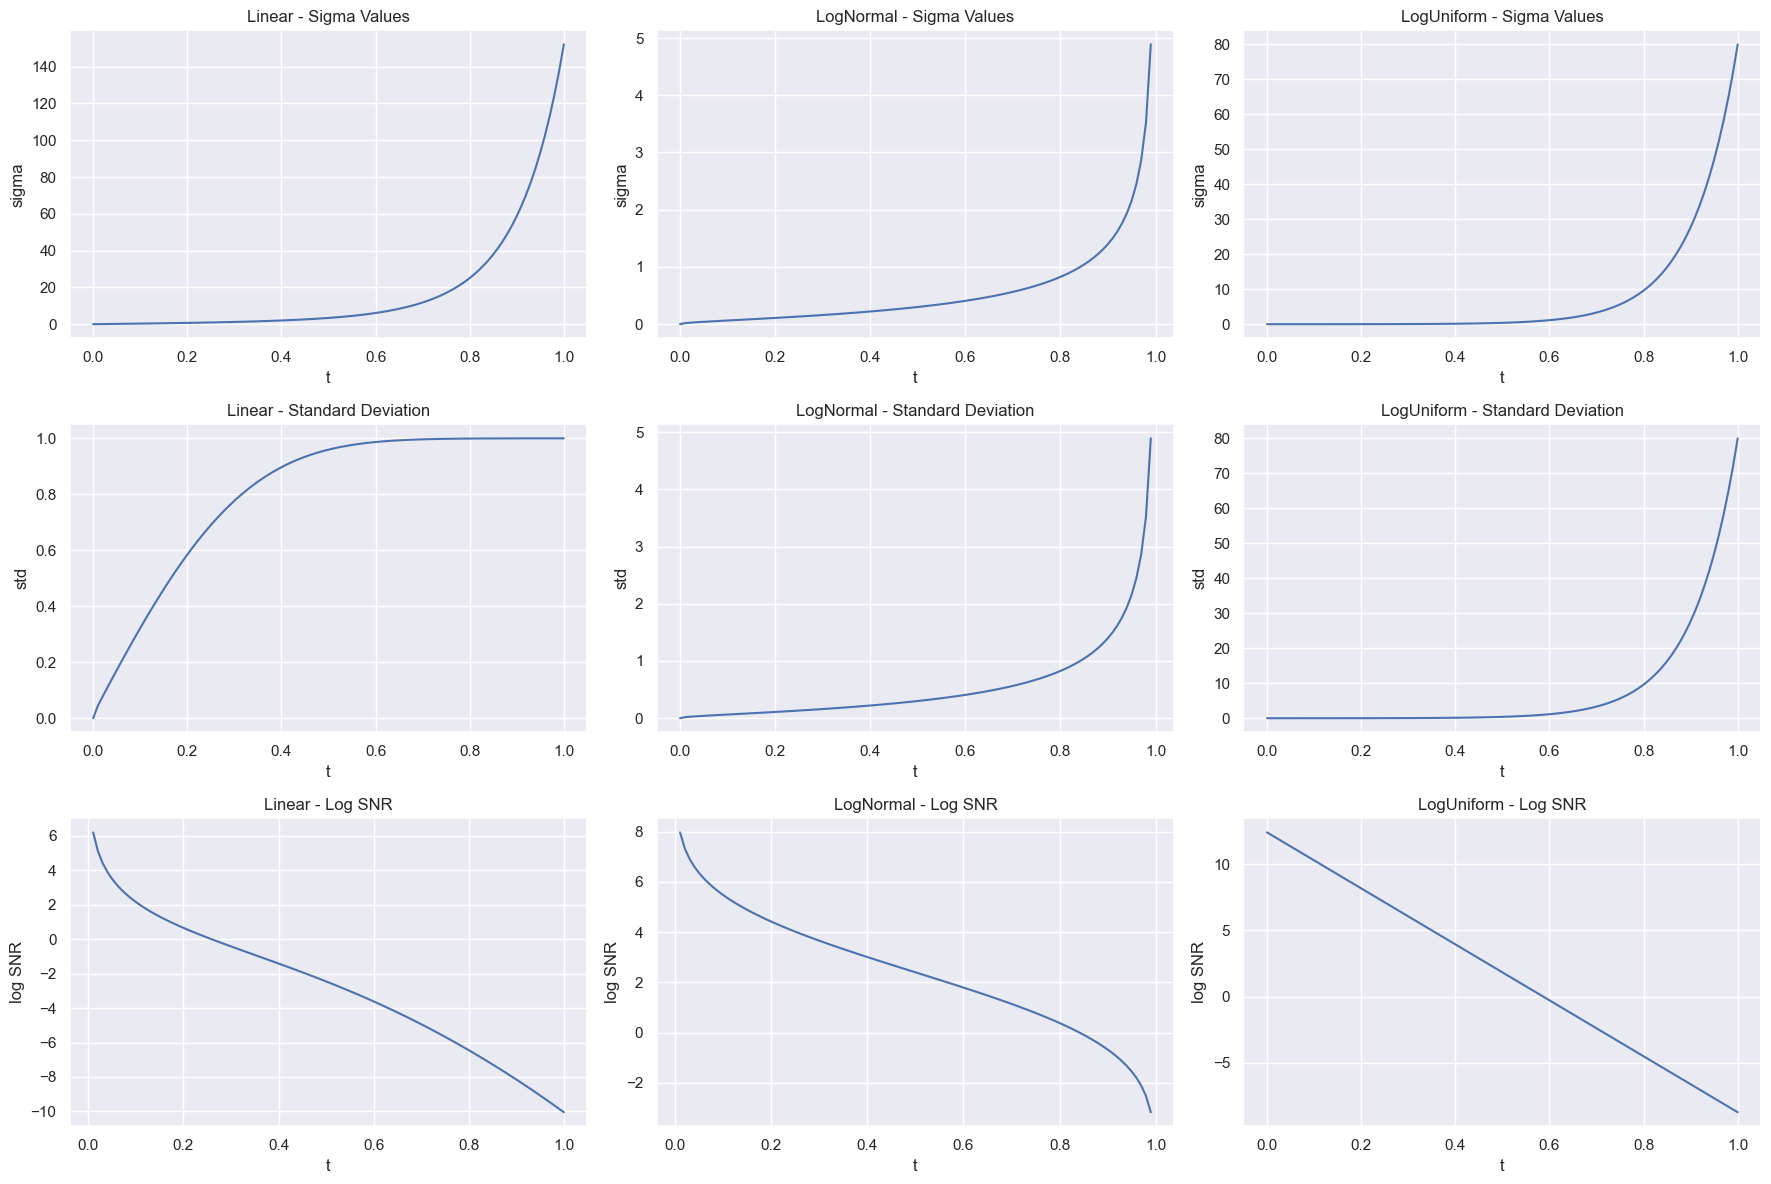

In [5]:
from training.noise_samplers.schedules import LinearNoiseSampler, LogNormalNoiseSampler, LogUniformNoiseSampler

# Create samplers for each type
samplers = {
    'Linear': LinearNoiseSampler(),
    'LogNormal': LogNormalNoiseSampler(),
    'LogUniform': LogUniformNoiseSampler()
}

# Create time points
t = torch.linspace(0, 1, 100)

# Create figure with subplots for each sampler
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

# Plot metrics for each sampler
for i, (name, sampler) in enumerate(samplers.items()):
    # Calculate metrics
    sigmas = sampler.sigma(t)
    s_t = sampler.signal(t)
    std = sigmas * s_t
    logsnr = sampler.logsnr(t)
    
    # Plot sigmas
    axes[0, i].plot(t, sigmas)
    axes[0, i].set_title(f'{name} - Sigma Values')
    axes[0, i].set_xlabel('t')
    axes[0, i].set_ylabel('sigma')
    
    # Plot standard deviation
    axes[1, i].plot(t, std)
    axes[1, i].set_title(f'{name} - Standard Deviation')
    axes[1, i].set_xlabel('t')
    axes[1, i].set_ylabel('std')
    
    # Plot log SNR
    axes[2, i].plot(t, logsnr)
    axes[2, i].set_title(f'{name} - Log SNR')
    axes[2, i].set_xlabel('t')
    axes[2, i].set_ylabel('log SNR')

plt.tight_layout()
plt.show()

## Visualize Forward Process

The EDM formulation is based on VE but how does VP looks for the noising process 

In [6]:
# Visualize Forward Process : TODO

# from training.noise_samplers.visualize import plot_forward_process_animation

# # Animated visualization
# plot_forward_process_animation(
#     x, sigma_sampler,
#     num_steps=50,  # Number of frames in animation
#     title='Forward Process Animation: Cosine Sampler'
# )

### Testing Nosing Process on Log Normal Noise Sampler

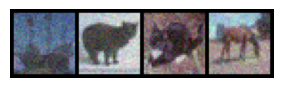

In [7]:
# Create Log Normal Noise Sampler
sigma_sampler = LogNormalNoiseSampler()

# Define a time step
t = 0.3 * torch.ones(x.shape[0])

# Generate a noisy state
noise = torch.randn_like(x)
sigmas = sigma_sampler.sigma(t)
noised_x = x + noise * expand_dims(sigmas, x.ndim)

# Visualize the noised data
plot_data(noised_x.cpu(), name="noised_toy_data", figsize=(3, 3))

## Networks

Now that we have define the noising process, we have to define the network that will predict the noise or signal. The EDM formulation cast everything to predict the signal (known as denoiser). For this purpose they proposed to construct a based model that acts similar to predicting the noise, and then a precondition netowk that accounts for scalings of the input/outputs: 

1. The noise prediction network (base model)
2. The Denoiser network using the EDM formulation

In [9]:
%load_ext autoreload
%autoreload 2
from networks.toy_network import MLP, AdvancedMLP
from models.lightning.edm_lightning import EDMLightning
import lightning as L
from networks.preconditioning import EDMDenoiser    
from utils.model_utils import get_model

if x.ndim == 2:
    # Base model 
    base_model = MLP(input_dim=2,
                    hidden_dim=config.network.hidden_dim, 
                    num_hidden_layers=config.network.num_hidden_layers, 
                    time_embedding_dim=config.network.time_embedding_dim)
    
    base_model = AdvancedMLP()

        # Choose Preconditioning scheme
    denoiser = EDMDenoiser(base_model, 
                        sigma_data=config.precond.sigma_data)
else:
    # Get Denoiser
    denoiser, base_model = get_model(config)

print("Loading model", config.network.name)
# Lightning Model
model = EDMLightning(model=denoiser, 
                     config=config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading model ddpmpp


In [11]:
# Testing the denoiser with dummy input 
if x.ndim == 2:
    input = torch.randn(10, 2)
    sigma = torch.ones(10) * 0.1
else: 
    input = torch.randn(10, 3, 32, 32)
    sigma = torch.ones(10) * 0.1

output = denoiser(input, sigma, None, None)
print(output.shape)

output = model.forward(input, sigma, None)
print(output.shape)


torch.Size([10, 3, 32, 32])
torch.Size([10, 3, 32, 32])


In [12]:
trainer = L.Trainer(
                    max_epochs=40,
                    accelerator="gpu",
                    devices="auto",
)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model, toy_dm)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name     | Type        | Params | Mode 
-------------------------------------------------
0 | denoiser | EDMDenoiser | 55.7 M | train
-------------------------------------------------
55.7 M    Trainable params
0         Non-trainable params
55.7 M    Total params
222.931   Total estimated model params size (MB)
246       Modules in train mode
0         Modules in eval mode


Epoch 0:  80%|████████  | 10018/12500 [14:06<03:29, 11.84it/s, v_num=0, train_loss_step=0.260]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

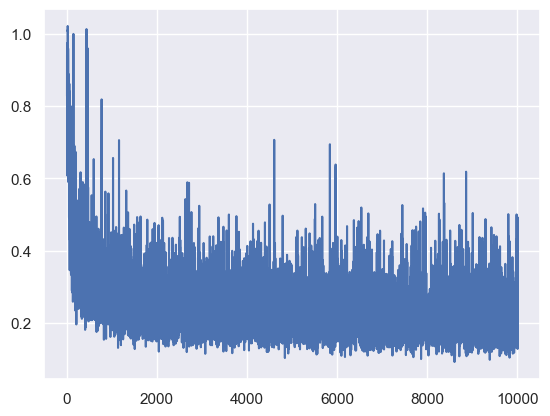

In [14]:
plt.plot(model.train_loss)

In [12]:
# denoiser = model.denoiser.eval()

In [15]:
%load_ext autoreload
from inference import KarrasDiffEq, KarrasHeun2Solver,KarrasNoiseSchedule
from inference import sample_trajectory_batch

# Create ODE and solver
ode = KarrasDiffEq(denoiser)
solver = KarrasHeun2Solver()

# sampling noise schedule
noise_schedule = KarrasNoiseSchedule(
    sigma_data=config['precond']['sigma_data'],
    sigma_min=config['precond']['sigma_min'],
    sigma_max=config['precond']['sigma_max'],
    rho=config['precond']['rho']
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# Generate samples with automatic shape detection
samples = sample_trajectory_batch(
    input_shape=x.shape[1:],  # Automatically use shape from input x
    ode=ode,
    solver=solver,
    noise_schedule=noise_schedule,
    batch_size=64,  # Typical batch size for image generation
    n_steps=50,
    device=device
)

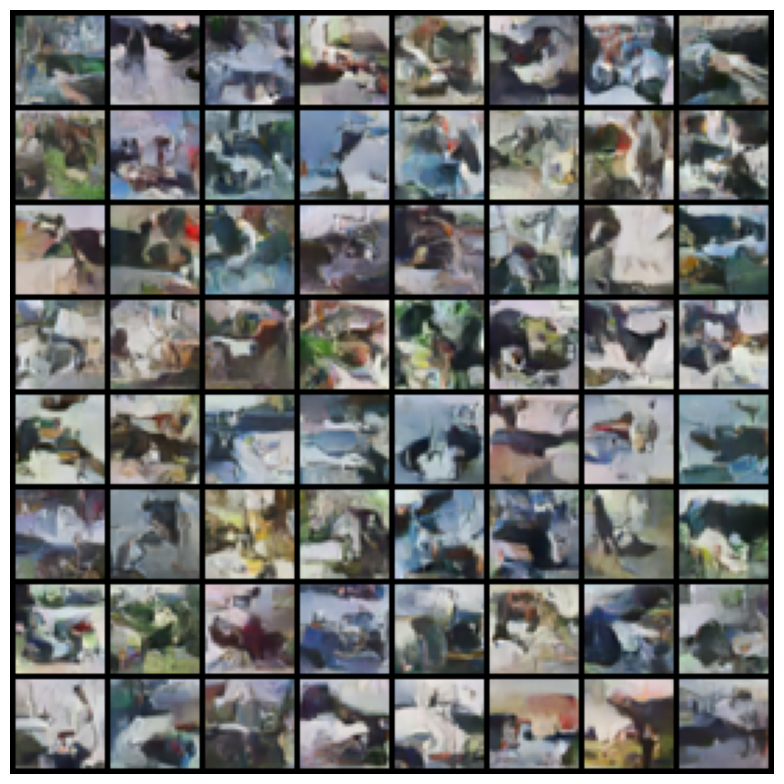

In [24]:
plot_data(samples[-1].detach().cpu().numpy(), figsize=(8, 8))

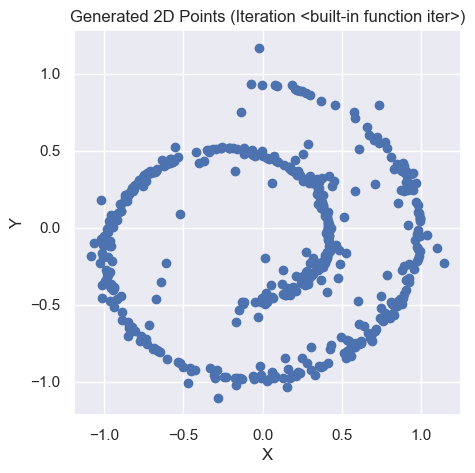

In [15]:
# Plot final samples
plt.figure(figsize=(5, 5))
final_samples = samples[-1].detach().cpu().numpy()
plt.scatter(final_samples[:, 0], final_samples[:, 1])
plt.title(f"Generated 2D Points (Iteration {iter})")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)

## Entropy Estimation 

**Gaussian kernel**

\begin{equation}
    p(x_t|x_0) = \mathcal{N}(x_t; s(t) x_0, s(t)^2 \sigma(t)^2 I)
\end{equation}

Leads to the following conditional entropy production 
\begin{equation} 
    \dot{\mathbf{H}}[\mathbf{x}_0|\mathbf{x}_t] = \frac{D \dot{\sigma}(t)}{\sigma(t)} - s(t)^2 \dot{\sigma}(t) \sigma(t) \mathbb{E}_{p_t(x_t)} [|| \nabla \log p_t(\mathbf{x}_t) ||^2 ]
\end{equation}

For EDM, with $\dot{\sigma}(t)=1$ this is 

\begin{equation} 
    \dot{\mathbf{H}}[\mathbf{x}_0|\mathbf{x}_t] = \frac{D}{t} - s(t)^2  \sigma(t) \mathbb{E}_{p_t(x_t)} [|| \nabla \log p_t(\mathbf{x}_t) ||^2 ]
\end{equation}

In [25]:
# Generate log-normal distribution parameters
mu = -1.2  # mean of the underlying normal distribution
sigma = 1.2  # standard deviation of the underlying normal distribution
t = np.linspace(0, 5, 1000)

# Compute log-normal PDF
pdf = (1 / (t * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))

# Plot
plt.figure(figsize=(8, 6))
plt.plot(t, pdf, 'b-', lw=2)
plt.title('Log-normal Distribution (μ=0, σ=1)')
plt.xlabel('t')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()


/tmp/ipykernel_3371290/1347875877.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf = (1 / (t * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
/tmp/ipykernel_3371290/1347875877.py:7: RuntimeWarning: invalid value encountered in log
  pdf = (1 / (t * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))


TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'Tensor'

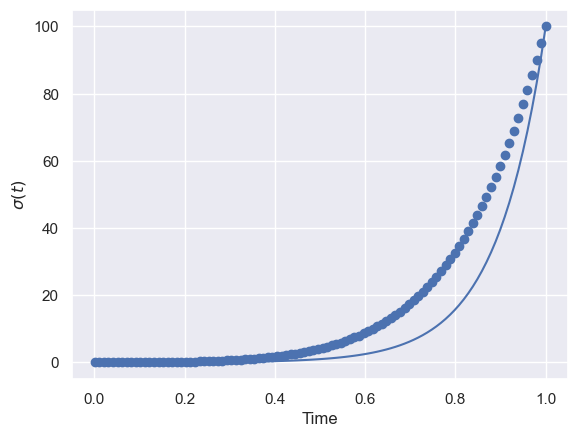

In [26]:
rho = 7.0
sigma_min = 0.01
sigma_max = 100
num_steps = 100
time_steps = torch.linspace(1e-3, 1, num_steps)
sigma_steps = (sigma_min ** (1 / rho) +  time_steps * (sigma_max ** (1 / rho) - sigma_min ** (1 / rho))) ** rho

import math 

log_sigma_min = math.log(sigma_min)
log_sigma_max = math.log(sigma_max)
log_sigma_steps = log_sigma_min + time_steps * (log_sigma_max - log_sigma_min)
plt.plot(time_steps, torch.exp(log_sigma_steps))
plt.scatter(time_steps, sigma_steps)
plt.xlabel("Time")
plt.ylabel("$\sigma(t)$")
plt.show()

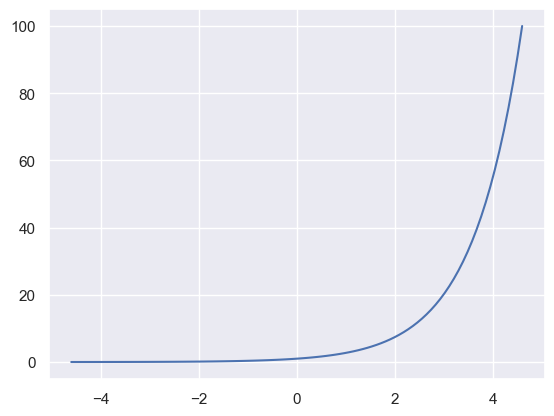

In [27]:
plt.plot(torch.linspace(log_sigma_min, log_sigma_max, steps=num_steps), torch.exp(torch.linspace(log_sigma_min, log_sigma_max, steps=num_steps)))

In [28]:
model.noise_sampler.sigma(time_steps)

tensor([0.0074, 0.0194, 0.0264, 0.0322, 0.0375, 0.0425, 0.0473, 0.0520, 0.0566,
        0.0611, 0.0656, 0.0700, 0.0745, 0.0789, 0.0834, 0.0879, 0.0924, 0.0970,
        0.1016, 0.1063, 0.1110, 0.1158, 0.1207, 0.1256, 0.1306, 0.1357, 0.1409,
        0.1462, 0.1516, 0.1570, 0.1626, 0.1683, 0.1741, 0.1800, 0.1861, 0.1923,
        0.1986, 0.2051, 0.2117, 0.2185, 0.2255, 0.2326, 0.2399, 0.2474, 0.2551,
        0.2631, 0.2712, 0.2796, 0.2882, 0.2971, 0.3063, 0.3157, 0.3254, 0.3355,
        0.3459, 0.3567, 0.3678, 0.3793, 0.3912, 0.4036, 0.4165, 0.4299, 0.4438,
        0.4583, 0.4734, 0.4891, 0.5056, 0.5228, 0.5409, 0.5598, 0.5797, 0.6007,
        0.6228, 0.6462, 0.6709, 0.6971, 0.7250, 0.7547, 0.7865, 0.8205, 0.8572,
        0.8967, 0.9396, 0.9863, 1.0374, 1.0937, 1.1560, 1.2256, 1.3040, 1.3933,
        1.4961, 1.6165, 1.7599, 1.9353, 2.1566, 2.4492, 2.8638, 3.5255, 4.8917,
           inf])

(array([66., 17.,  7.,  4.,  2.,  1.,  0.,  1.,  0.,  1.]),
 array([0.00738515, 0.49581733, 0.98424953, 1.47268164, 1.96111381,
        2.4495461 , 2.93797827, 3.42641044, 3.91484261, 4.40327454,
        4.89170694]),
 <BarContainer object of 10 artists>)

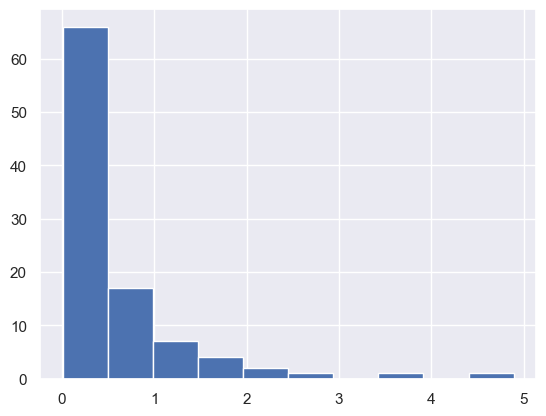

In [29]:
sigmas = model.noise_sampler(batch_size=10000)
sigmas_inverse_method = model.noise_sampler.sigma(time_steps)
plt.hist(sigmas_inverse_method[:-1])
# plt.hist(sigmas)
# plt.show()

In [30]:
sigma_min = 0.01
sigma_max = 100
rho = 7.0

time_steps = torch.linspace(1e-3, 1, num_steps)
sigma_steps = (sigma_min ** (1 / rho) +  time_steps * (sigma_max ** (1 / rho) - sigma_min ** (1 / rho))) ** rho


In [31]:
model.denoiser.eval().to(device)
print()

## Manual Implementation of the dH/dt

In [46]:
# Choose a time step
t = torch.ones(x.shape[0], device=device) * 0.1
x = x.to(device)
noise = noise.to(device)

sigma_t = (sigma_min ** (1 / rho) +  t * (sigma_max ** (1 / rho) - sigma_min ** (1 / rho))) ** rho
sigma_t = torch.ones(x.shape[0], device=device) * sigma_t 

x_t = x + noise * expand_dims(sigma_t, x.ndim)
score = model.compute_score(x_t, sigma_t)
signal_t = model.noise_sampler.signal(t)

mean_square_l2_norm_score = torch.mean(torch.sum(score**2, dim=-1))
D = 2
entropy_derivative = D/t - signal_t**2 * sigma_t * mean_square_l2_norm_score 
entropy_derivative.mean()

tensor(-420.5690, device='cuda:0', grad_fn=<MeanBackward0>)

### Validation 

In [54]:
%reload_ext autoreload
%autoreload 2

from models.entropy_analysis import EntropyAnalyzer

entropy_analyzer = EntropyAnalyzer()
entropy_analyzer.compute_time_derivative_entropy(model, x_t, t)

tensor(415969.5938, device='cuda:0')

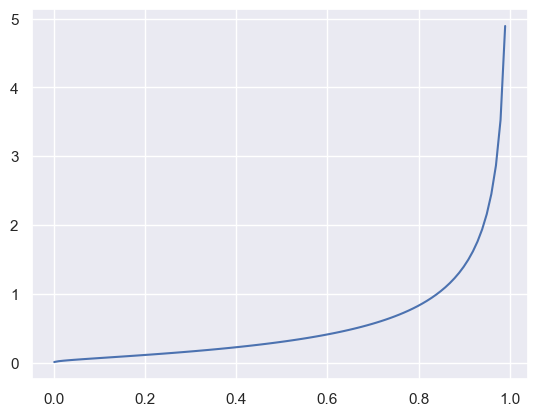

In [56]:
time_steps = torch.linspace(1e-3, 1, 100)
sigmas = (sigma_min ** (1 / rho) +  time_steps * (sigma_max ** (1 / rho) - sigma_min ** (1 / rho))) ** rho

sigmas2 = LogNormalNoiseSampler().sigma(time_steps)

# plt.plot(time_steps, sigmas)
plt.plot(time_steps, sigmas2)
plt.show()

In [57]:
from tqdm import tqdm

Computing entropy derivatives: 100%|██████████| 100/100 [00:01<00:00, 54.04it/s]


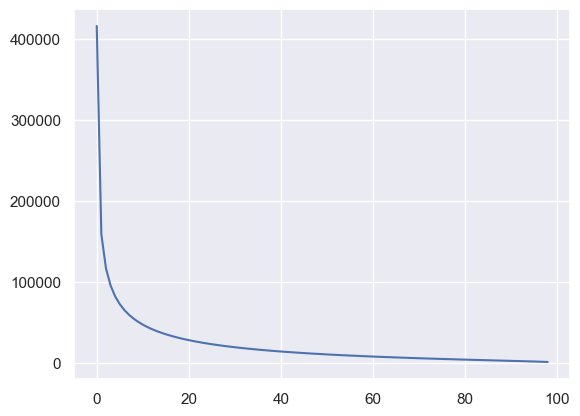

In [58]:
entropy_derivatives = []

with torch.no_grad():
    for t in tqdm(time_steps, desc="Computing entropy derivatives"):
        t = torch.ones(x.shape[0], device=device) * t
        entropy_derivatives.append(entropy_analyzer.compute_time_derivative_entropy(model, x, t))

entropy_derivatives = torch.stack(entropy_derivatives)

plt.plot(entropy_derivatives.cpu().numpy())

Computing entropy derivatives: 100%|██████████| 1000/1000 [00:18<00:00, 54.02it/s]


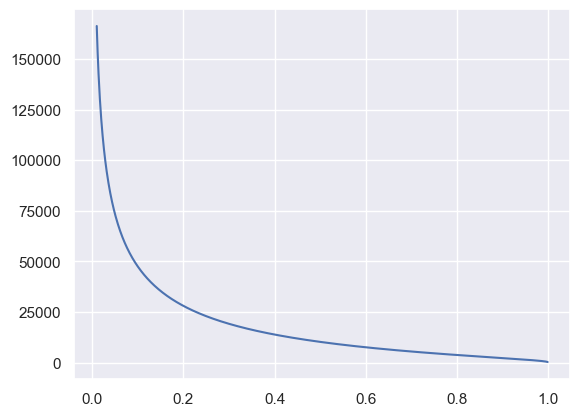

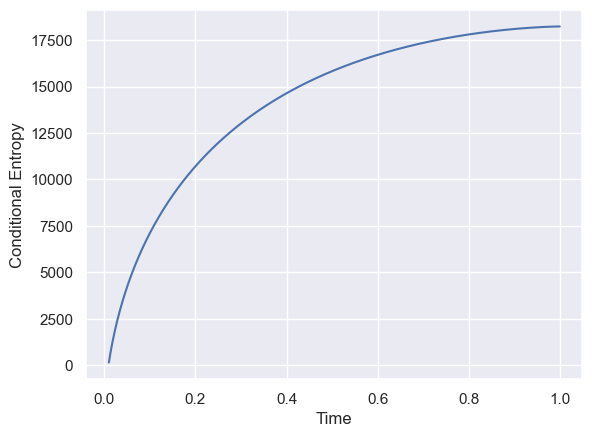

In [59]:
time_steps = torch.linspace(1e-2, 1-1e-3, 1000)
entropy_derivatives = entropy_analyzer.get_entropy_derivative(model, x, time_steps)
plt.plot(time_steps, entropy_derivatives.cpu().numpy())
plt.show()

conditional_entropy = entropy_analyzer.compute_conditional_entropy(entropy_derivatives, time_steps)
plt.plot(time_steps, conditional_entropy.cpu().numpy())
plt.ylabel("Conditional Entropy")
plt.xlabel("Time")
plt.show()


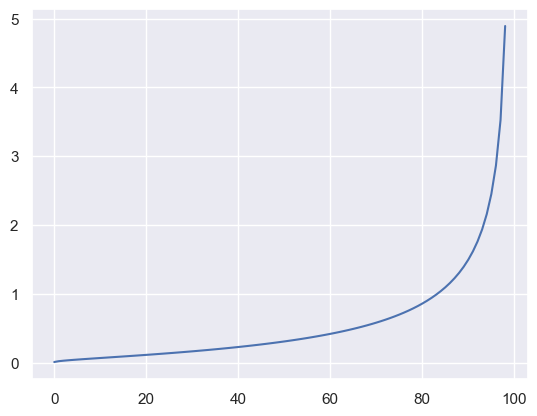

In [60]:
noise_sampler = model.noise_sampler

# Get timesteps linearly spaced between 1e-3 and 1
timesteps = torch.linspace(1e-3, 1, 100)

# Get noise levels
sigmas = noise_sampler.sigma(timesteps)

# Get score function
# score = model.compute_score(x, timesteps)

plt.plot(sigmas)



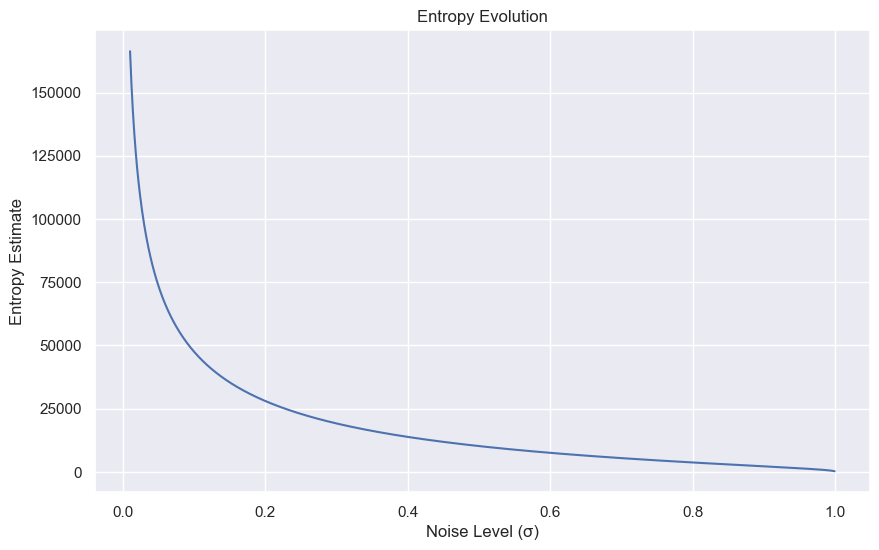

In [61]:
entropy_analyzer.plot_entropy_over_time(time_steps.cpu().numpy(), entropy_derivatives.cpu().numpy())

## Design of the Entropic Sampler

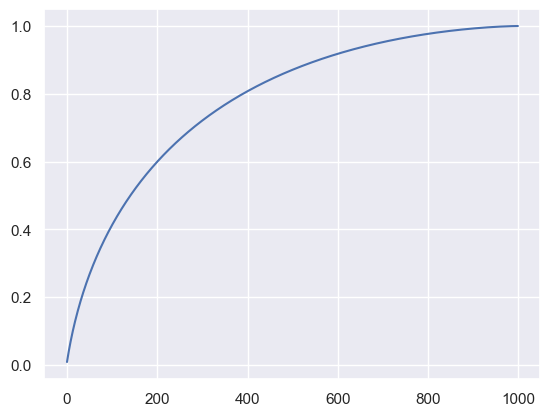

In [62]:

# Ensure entropy is non-negative
entropy = torch.clamp(conditional_entropy, min=0)

# Normalize to [0, 1]
cdf = entropy / entropy.max()

# Ensure monotonicity
cdf = torch.cummax(cdf, dim=0)[0]

plt.plot(cdf.cpu().numpy())


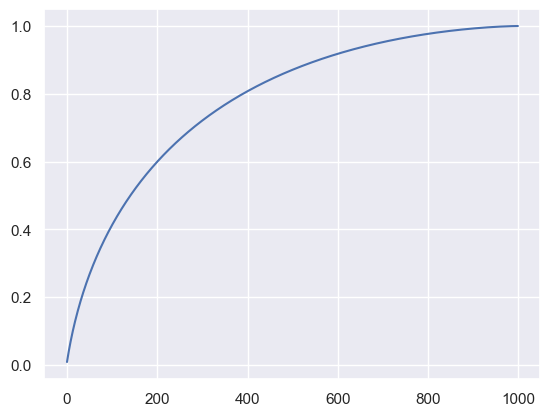

In [66]:
from samplers.edm_entropic_sampler import EDMEntropicSampler

entropic_sampler = EDMEntropicSampler(base_sampler=noise_sampler,
                                      timesteps=time_steps,
                                      cdf=cdf)

# entropic_sampler.update_entropy_distribution(model, x)

plt.plot(entropic_sampler.cdf.cpu().numpy())

In [67]:
entropic_sampler.cdf

tensor([0.0088, 0.0173, 0.0255, 0.0334, 0.0410, 0.0484, 0.0556, 0.0625, 0.0693,
        0.0759, 0.0824, 0.0887, 0.0948, 0.1009, 0.1068, 0.1125, 0.1182, 0.1238,
        0.1292, 0.1346, 0.1398, 0.1450, 0.1501, 0.1551, 0.1600, 0.1649, 0.1697,
        0.1744, 0.1790, 0.1836, 0.1881, 0.1926, 0.1970, 0.2013, 0.2056, 0.2098,
        0.2140, 0.2181, 0.2222, 0.2262, 0.2302, 0.2342, 0.2380, 0.2419, 0.2457,
        0.2495, 0.2532, 0.2569, 0.2605, 0.2642, 0.2677, 0.2713, 0.2748, 0.2783,
        0.2817, 0.2851, 0.2885, 0.2918, 0.2952, 0.2984, 0.3017, 0.3049, 0.3081,
        0.3113, 0.3145, 0.3176, 0.3207, 0.3237, 0.3268, 0.3298, 0.3328, 0.3358,
        0.3387, 0.3416, 0.3445, 0.3474, 0.3503, 0.3531, 0.3559, 0.3587, 0.3615,
        0.3643, 0.3670, 0.3697, 0.3724, 0.3751, 0.3777, 0.3804, 0.3830, 0.3856,
        0.3882, 0.3907, 0.3933, 0.3958, 0.3984, 0.4009, 0.4033, 0.4058, 0.4083,
        0.4107, 0.4131, 0.4155, 0.4179, 0.4203, 0.4226, 0.4250, 0.4273, 0.4296,
        0.4320, 0.4342, 0.4365, 0.4388, 

In [68]:
cdf_np = entropic_sampler.cdf.cpu().numpy()
cdf_np = entropic_sampler.cdf.cpu().numpy()



In [69]:
cdf_np

array([0.00884325, 0.01732973, 0.02549824, 0.03338076, 0.0410041 ,
       0.04839095, 0.0555608 , 0.06253048, 0.0693147 , 0.07592641,
       0.08237704, 0.0886768 , 0.09483481, 0.10085928, 0.10675768,
       0.11253672, 0.11820257, 0.12376083, 0.12921666, 0.13457483,
       0.13983972, 0.14501536, 0.15010555, 0.15511373, 0.16004322,
       0.16489702, 0.169678  , 0.17438884, 0.17903201, 0.18360992,
       0.18812475, 0.1925786 , 0.19697343, 0.20131111, 0.20559345,
       0.2098221 , 0.21399868, 0.21812467, 0.22220153, 0.22623065,
       0.23021333, 0.23415081, 0.23804426, 0.24189487, 0.24570371,
       0.24947181, 0.2532002 , 0.2568898 , 0.26054156, 0.26415637,
       0.26773506, 0.27127847, 0.2747874 , 0.27826256, 0.2817047 ,
       0.28511453, 0.2884927 , 0.2918399 , 0.29515675, 0.29844388,
       0.30170193, 0.3049313 , 0.30813268, 0.31130654, 0.31445345,
       0.31757388, 0.3206683 , 0.3237372 , 0.32678103, 0.32980028,
       0.3327953 , 0.33576655, 0.33871442, 0.34163934, 0.34454

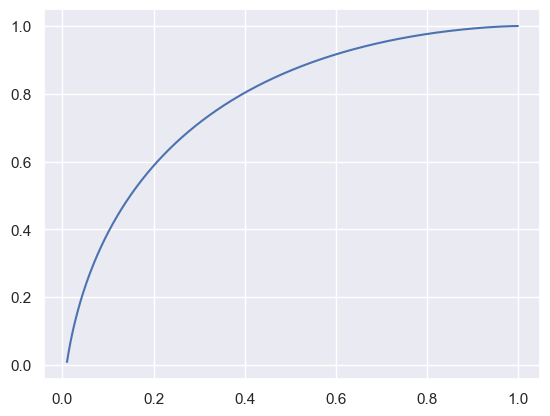

In [70]:
from scipy.interpolate import PchipInterpolator

time_steps = entropic_sampler.time_steps.cpu().numpy()
cdf_np = entropic_sampler.cdf.cpu().numpy()
plt.plot(time_steps, cdf_np)
plt.show()

# Add small epsilon to cdf to avoid zero values
eps = np.finfo(cdf_np.dtype).eps
cdf_np = cdf_np + np.arange(len(cdf_np)) * eps

# Create interpolator
interpolator = PchipInterpolator(cdf_np, time_steps)

# Sample from interpolator
sampled_time_steps = interpolator(np.random.rand(1000))
# sampled_time_steps


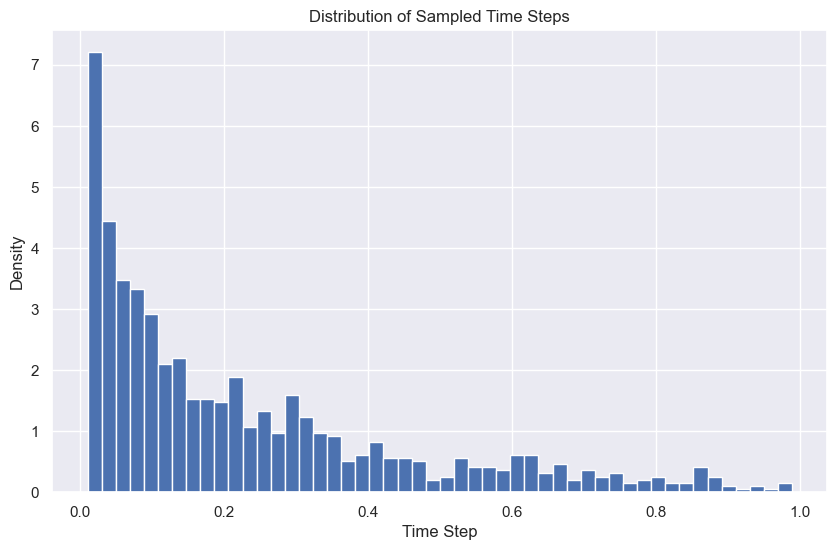

In [71]:
# Sample 1000 time steps
sampled_time_steps = entropic_sampler.sample(1000)

# Plot histogram of sampled time steps
plt.figure(figsize=(10, 6))
plt.hist(sampled_time_steps.cpu().numpy(), bins=50, density=True)
plt.title('Distribution of Sampled Time Steps')
plt.xlabel('Time Step')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for epoch in range(100):
    for batch in dataloader:
        x, _ = batch
        loss = net.get_loss(x, None)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

## Pretrain network


In [30]:
from utils.model_utils import download_network


model_root = 'https://nvlabs-fi-cdn.nvidia.com/edm/pretrained'
model_path = f"{model_root}/edm-cifar10-32x32-cond-vp.pkl"

net = download_network(network_url=model_path)



Checking cache /home/gabriel/.cache/dnnlib/downloads 8a0cade18e36ff627fc6c7a9dce1bd11


In [33]:
net

EDMPrecond(
  (model): SongUNet(
    (map_noise): PositionalEmbedding()
    (map_label): Linear()
    (map_augment): Linear()
    (map_layer0): Linear()
    (map_layer1): Linear()
    (enc): ModuleDict(
      (32x32_conv): Conv2d()
      (32x32_block0): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
        (skip): Conv2d()
      )
      (32x32_block1): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block2): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block3): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (16x16_down): UNetBlock(


In [ ]:




# Download the model
# model_path = download_network(f"{model_root}/edm_cifar10_uncond_256x256_cond_1024x1024.pth")

# Load the model
# model = torch.load(model_path)


Checking cache /home/gabriel/.cache/dnnlib/downloads 8a0cade18e36ff627fc6c7a9dce1bd11
Downloaded model


In [26]:
net

EDMPrecond(
  (model): SongUNet(
    (map_noise): PositionalEmbedding()
    (map_label): Linear()
    (map_augment): Linear()
    (map_layer0): Linear()
    (map_layer1): Linear()
    (enc): ModuleDict(
      (32x32_conv): Conv2d()
      (32x32_block0): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
        (skip): Conv2d()
      )
      (32x32_block1): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block2): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block3): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (16x16_down): UNetBlock(
